# Create a hetnet of MSigDB genesets

This script was modified from https://github.com/dhimmel/integrate.

## For the automatic interpretation of gene expression compression features

The script creates an MSigDB hetnet as described in the eLIFE publication _"Systematic integration of biomedical knowledge prioritizes drugs for repurposing"_ by [Himmelstein et al. 2017](https://doi.org/10.7554/eLife.26726)

In [1]:
import os
import csv
import pandas as pd
import seaborn as sns

import hetio.hetnet
import hetio.readwrite
import hetio.stats

In [2]:
%matplotlib inline

## Define the metagraph and instantiate the graph

In [3]:
kind_to_abbev = {
    
    # metanodes
    'Gene': 'G',

    'Cancer-Hallmarks': 'H',
    'Positional-Gene-Sets': 'C1',
    'Curated-Gene-Sets': 'C2',
    'Motif-Gene-Sets': 'C3',
    'Computational-Gene-Sets': 'C4',
    'GO-Gene-Sets': 'C5',
    'Oncogenic-Gene-Sets': 'C6',
    'Immunologic-Gene-Sets': 'C7',
    
    # metaedges
    'participates': 'p',
}

metaedge_tuples = [
    ('Gene', 'Cancer-Hallmarks', 'participates', 'both'),
    ('Gene', 'Positional-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Curated-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Motif-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Computational-Gene-Sets', 'participates', 'both'),
    ('Gene', 'GO-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Oncogenic-Gene-Sets', 'participates', 'both'),
    ('Gene', 'Immunologic-Gene-Sets', 'participates', 'both'),
]

In [4]:
# Initialize the graph
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Get all genes found in MSigDB

In [5]:
full_msigdb_file = os.path.join('data', 'full_msigdb_binary_matrix.tsv.bz2')
msigdb_df = pd.read_table(full_msigdb_file, index_col=0)

print(msigdb_df.shape)
msigdb_df.head()

(32431, 17356)


,AAACCAC_MIR140,AAAGACA_MIR511,AAAGGAT_MIR501,AAAGGGA_MIR204_MIR211,AAANWWTGC_UNKNOWN,AAAYRNCTG_UNKNOWN,AAAYWAACM_HFH4_01,AACATTC_MIR4093P,AACGGTT_MIR451,AACTGAC_MIR223,...,chrxq21,chrxq22,chrxq23,chrxq24,chrxq25,chrxq26,chrxq27,chrxq28,chryp11,chryq11
1/2-SBSRNA4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.8-1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.8-1.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.8-1.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.8-1.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


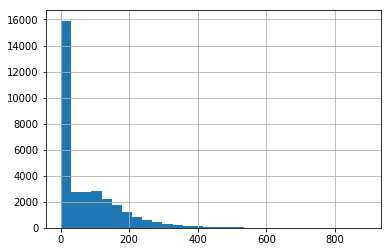

In [6]:
# Ask the distribution of pathway sizes
msigdb_df.sum(axis=1).sort_values().hist(bins=30);

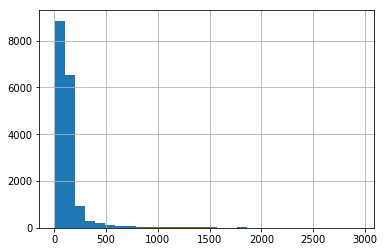

In [7]:
# What about the distribution of gene participation?
msigdb_df.sum(axis=0).sort_values().hist(bins=30);

## Gene Nodes

In [8]:
# Load curated gene names from versioned resource 
commit = 'a7362748a34211e5df6f2d185bb3246279760546'
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/{}/data/genes-human.tsv'.format(commit)
gene_df = pd.read_table(url)

# Only consider protein-coding genes
gene_df = (
    gene_df.query("type_of_gene == 'protein-coding'")
    .drop_duplicates('Symbol')
)

coding_genes = set(gene_df['GeneID'])
print(gene_df.shape)
gene_df.head(2)

(20943, 7)


,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.4,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


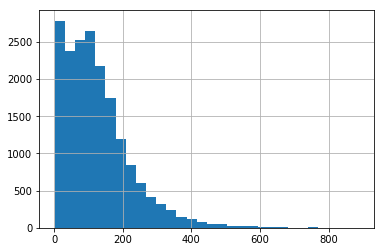

In [9]:
# Subset the msigdb genes to the gene curation above
common_subset_genes = set(gene_df['Symbol']).intersection(set(msigdb_df.index))
msigdb_subset_genes_df = msigdb_df.loc[common_subset_genes, :]

# What is the new distribution of pathway sizes?
msigdb_subset_genes_df.sum(axis=1).sort_values().hist(bins=30);

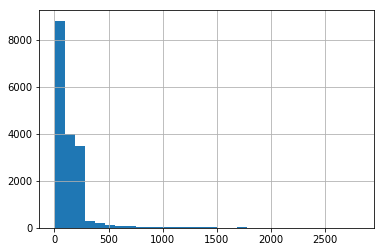

In [10]:
# What is the new distribution of gene representation?
msigdb_subset_genes_df.sum(axis=0).sort_values().hist(bins=30);

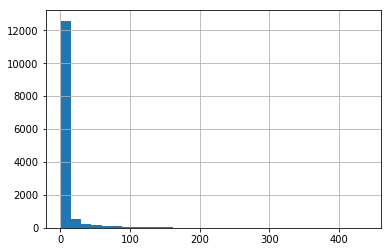

In [11]:
# The genes that were removed from MSigDB participate mostly in few pathways
diff_genes = set(msigdb_df.index).difference(gene_df['Symbol'])
msigdb_other_genes_df = msigdb_df.loc[diff_genes, :]
msigdb_other_genes_df.sum(axis=1).sort_values().hist(bins=30)

## Add genes as nodes to the graph

Use the gene-symbol identifier for easier interpretation

In [12]:
%%time
for i, row in gene_df.iterrows():
    # Build dictionary of descriptive elements for each gene
    meta_data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row['GeneID']),
        'license': 'CC0 1.0',
    }
    
    if pd.notnull(row['chromosome']):
        meta_data['chromosome'] = row['chromosome']

    # Add genes to graph
    graph.add_node(kind='Gene', identifier=row['Symbol'], name=row['GeneID'],
                   data=meta_data)

CPU times: user 2.83 s, sys: 12 ms, total: 2.84 s
Wall time: 2.85 s


## Add gene set nodes and associated genes as edges

Add each MSigDB collection as distinct nodes with a `participates` edge for representative gene sets and corresponding membership.

In [13]:
def add_msigdb_node_to_graph(current_graph, collection_file, collection_kind,
                             collection_source, gene_list, min_geneset_size=4,
                             max_geneset_size=1000, license='CC BY 4.0'):
    """
    Add nodes and edges to current graph based on geneset memembership of collection
    
    Arguments:
    current_graph - a hetnet object to add node-edge info to
    collection_file - location of msigdb file
    collection_kind - the kind of node already initialized in the graph
    collection_source - alternative ID for collection
    gene_list - a list of genes to consider when building the graph
    min_geneset_size - filter out a given gene set if it has fewer genes
    max_geneset_size - filter out a given gene set if it has more genes
    license - given license associated with node
    
    Output:
    Adds to current graph; Returns the amount of filtered genesets
    """
    
    # Build meta data dictionary to store node info
    meta_data = {'license': license, 'source': collection_source}
    
    # Open the .gmt file and process each geneset
    filtered_genesets = []
    with open(collection_file, 'r') as collection_fh:
        collection_reader = csv.reader(collection_fh, delimiter='\t')

        for row in collection_reader:
            # Get geneset and and metadata info
            geneset_name = row[0]
            meta_data['url'] = row[1]
            
            # Process geneset membership
            genes = row[2:]

            # Filter geneset if its too big or small
            if min_geneset_size > len(genes) or len(genes) > max_geneset_size:
                filtered_genesets.append(geneset_name)
                continue
                
            # Add the genesetname as a node (based on collection) to the graph
            current_graph.add_node(kind=collection_kind, identifier=geneset_name, data=meta_data)

            # Loop through all genes and add to the graph it should be considered
            for gene in genes:
                if gene in gene_list:
                    source_id = ('Gene', gene)
                    target_id = (collection_kind, geneset_name)
                    
                    edge_data = meta_data.copy()
                    edge_data['unbiased'] = False

                    current_graph.add_edge(source_id, target_id, 'participates', 'both', edge_data)

    return filtered_genesets

In [14]:
%%time
hallmarks_file = 'data/h.all.v6.1.symbols.gmt'
hallmark_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                             collection_file=hallmarks_file,
                                             collection_kind='Cancer-Hallmarks',
                                             collection_source='MSigDB-H',
                                             gene_list=common_subset_genes)

CPU times: user 120 ms, sys: 8 ms, total: 128 ms
Wall time: 137 ms


In [15]:
%%time
positional_file = 'data/c1.all.v6.1.symbols.gmt'
positional_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                               collection_file=positional_file,
                                               collection_kind='Positional-Gene-Sets',
                                               collection_source='MSigDB-C1',
                                               gene_list=common_subset_genes)

CPU times: user 412 ms, sys: 0 ns, total: 412 ms
Wall time: 434 ms


In [16]:
%%time
curated_file = 'data/c2.all.v6.1.symbols.gmt'
curated_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                            collection_file=curated_file,
                                            collection_kind='Curated-Gene-Sets',
                                            collection_source='MSigDB-C2',
                                            gene_list=common_subset_genes)

CPU times: user 8.8 s, sys: 148 ms, total: 8.95 s
Wall time: 9.17 s


In [17]:
%%time
motif_file = 'data/c3.all.v6.1.symbols.gmt'
motif_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                          collection_file=motif_file,
                                          collection_kind='Motif-Gene-Sets',
                                          collection_source='MSigDB-C3',
                                          gene_list=common_subset_genes)

CPU times: user 3.43 s, sys: 44 ms, total: 3.47 s
Wall time: 3.49 s


In [18]:
%%time
computational_file = 'data/c4.all.v6.1.symbols.gmt'
computational_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                                  collection_file=computational_file,
                                                  collection_kind='Computational-Gene-Sets',
                                                  collection_source='MSigDB-C4',
                                                  gene_list=common_subset_genes)

CPU times: user 2.33 s, sys: 16 ms, total: 2.35 s
Wall time: 2.38 s


In [19]:
%%time
go_file = 'data/c5.all.v6.1.symbols.gmt'
go_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                       collection_file=go_file,
                                       collection_kind='GO-Gene-Sets',
                                       collection_source='MSigDB-C5',
                                       gene_list=common_subset_genes) 

CPU times: user 11.1 s, sys: 208 ms, total: 11.3 s
Wall time: 11.4 s


In [20]:
%%time
oncogenic_file = 'data/c6.all.v6.1.symbols.gmt'
oncogenic_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                              collection_file=oncogenic_file,
                                              collection_kind='Oncogenic-Gene-Sets',
                                              collection_source='MSigDB-C6',
                                              gene_list=common_subset_genes)

CPU times: user 492 ms, sys: 20 ms, total: 512 ms
Wall time: 513 ms


In [21]:
%%time
immunologic_file = 'data/c7.all.v6.1.symbols.gmt'
immunologic_filtered = add_msigdb_node_to_graph(current_graph=graph,
                                                collection_file=immunologic_file,
                                                collection_kind='Immunologic-Gene-Sets',
                                                collection_source='MSigDB-C7',
                                                gene_list=common_subset_genes)

CPU times: user 19.1 s, sys: 312 ms, total: 19.4 s
Wall time: 19.4 s


## Network visualizations and stats

In [22]:
# Export node degree tables
node_degree_file = os.path.join('results', 'msigdb_node_degrees.xlsx')
hetio.stats.degrees_to_excel(graph, node_degree_file)

In [23]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)

metanode_file = os.path.join('results', 'msigdb_metanode_summary.tsv')
metanode_df.to_csv(metanode_file, sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
2,Cancer-Hallmarks,H,1,50,0
1,Computational-Gene-Sets,C4,1,858,0
6,Curated-Gene-Sets,C2,1,4709,0
7,GO-Gene-Sets,C5,1,5799,0
4,Gene,G,8,20943,2543
0,Immunologic-Gene-Sets,C7,1,4872,0
8,Motif-Gene-Sets,C3,1,819,0
5,Oncogenic-Gene-Sets,C6,1,189,0
3,Positional-Gene-Sets,C1,1,326,0


In [24]:
# Total number of nodes
metanode_df.nodes.sum()

38565

In [25]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_file = os.path.join('results', 'msigdb_metaedges.tsv')
metaedge_df = metaedge_df.merge(pd.DataFrame(rows))
metaedge_df.to_csv(metaedge_file, sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,Gene - participates - Cancer-Hallmarks,GpH,7255,4331,50,0
1,Gene - participates - Computational-Gene-Sets,GpC4,88629,9615,858,0
2,Gene - participates - Curated-Gene-Sets,GpC2,389273,17506,4709,0
3,Gene - participates - GO-Gene-Sets,GpC5,510549,15526,5799,0
4,Gene - participates - Immunologic-Gene-Sets,GpC7,896263,17291,4872,0
5,Gene - participates - Motif-Gene-Sets,GpC3,163394,12833,819,0
6,Gene - participates - Oncogenic-Gene-Sets,GpC6,29471,10352,189,0
7,Gene - participates - Positional-Gene-Sets,GpC1,17809,17630,326,0


In [26]:
# Summary of different styles for representing each metaedge
metaedge_style_file = os.path.join('results', 'msigdb_metaedge_styles.tsv')
metaedge_style_df = hetio.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.to_csv(metaedge_style_file, sep='\t', index=False)
metaedge_style_df

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
14,Cancer-Hallmarks - participates - Gene,Cancer-Hallmarks–participates–Gene,Gene - participates - Cancer-Hallmarks,HpG,GpH,Cancer-Hallmarks,Gene,1
15,Computational-Gene-Sets - participates - Gene,Computational-Gene-Sets–participates–Gene,Gene - participates - Computational-Gene-Sets,C4pG,GpC4,Computational-Gene-Sets,Gene,1
4,Curated-Gene-Sets - participates - Gene,Curated-Gene-Sets–participates–Gene,Gene - participates - Curated-Gene-Sets,C2pG,GpC2,Curated-Gene-Sets,Gene,1
13,GO-Gene-Sets - participates - Gene,GO-Gene-Sets–participates–Gene,Gene - participates - GO-Gene-Sets,C5pG,GpC5,GO-Gene-Sets,Gene,1
6,Gene - participates - Cancer-Hallmarks,Gene–participates–Cancer-Hallmarks,Gene - participates - Cancer-Hallmarks,GpH,GpH,Gene,Cancer-Hallmarks,0
8,Gene - participates - Computational-Gene-Sets,Gene–participates–Computational-Gene-Sets,Gene - participates - Computational-Gene-Sets,GpC4,GpC4,Gene,Computational-Gene-Sets,0
10,Gene - participates - Curated-Gene-Sets,Gene–participates–Curated-Gene-Sets,Gene - participates - Curated-Gene-Sets,GpC2,GpC2,Gene,Curated-Gene-Sets,0
0,Gene - participates - GO-Gene-Sets,Gene–participates–GO-Gene-Sets,Gene - participates - GO-Gene-Sets,GpC5,GpC5,Gene,GO-Gene-Sets,0
7,Gene - participates - Immunologic-Gene-Sets,Gene–participates–Immunologic-Gene-Sets,Gene - participates - Immunologic-Gene-Sets,GpC7,GpC7,Gene,Immunologic-Gene-Sets,0
5,Gene - participates - Motif-Gene-Sets,Gene–participates–Motif-Gene-Sets,Gene - participates - Motif-Gene-Sets,GpC3,GpC3,Gene,Motif-Gene-Sets,0


In [27]:
# Number of edges in the network
metaedge_df.edges.sum()

2102643

In [28]:
# How many genesets were filtered?
{'Cancer-Hallmarks': len(hallmark_filtered),
 'Positional-Gene-Sets': len(positional_filtered),
 'Curated-Gene-Sets': len(curated_filtered),
 'Motif-Gene-Sets': len(motif_filtered),
 'Computational-Gene-Sets': len(computational_filtered),
 'GO-Gene-Sets': len(go_filtered),
 'Oncogenic-Gene-Sets': len(oncogenic_filtered),
 'Immunologic-Gene-Sets': len(immunologic_filtered)}

{'Cancer-Hallmarks': 0,
 'Computational-Gene-Sets': 0,
 'Curated-Gene-Sets': 29,
 'GO-Gene-Sets': 118,
 'Immunologic-Gene-Sets': 0,
 'Motif-Gene-Sets': 17,
 'Oncogenic-Gene-Sets': 0,
 'Positional-Gene-Sets': 0}

## Save graph

In [29]:
%%time
# Write nodes to a table
nodes_file = os.path.join('hetnets', 'msigdb_nodes.tsv')
hetio.readwrite.write_nodetable(graph, nodes_file)

# Write edges to a table
edges_file = os.path.join('hetnets', 'msigdb_edges.sif.gz')
hetio.readwrite.write_sif(graph, edges_file)

CPU times: user 38 s, sys: 44 ms, total: 38 s
Wall time: 38.3 s


In [30]:
%%time
# Write a subset of edges to a table
edges_file = os.path.join('hetnets', 'msigdb_edges-10.sif.gz')
hetio.readwrite.write_sif(graph, edges_file, max_edges=10)

edges_file = os.path.join('hetnets', 'msigdb_edges-5k.sif.gz')
hetio.readwrite.write_sif(graph, edges_file, max_edges=5000)

CPU times: user 6.96 s, sys: 36 ms, total: 6.99 s
Wall time: 7.17 s


In [31]:
%%time
# Write metagraph as json
metagraph_file = os.path.join('hetnets', 'msigdb_metagraph.json')
hetio.readwrite.write_metagraph(metagraph, metagraph_file)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.12 ms


In [32]:
%%time
# Write graph as json
hetnet_json_path = os.path.join('hetnets', 'msigdb_hetnet.json.bz2')
hetio.readwrite.write_graph(graph, hetnet_json_path)

CPU times: user 4min 55s, sys: 648 ms, total: 4min 56s
Wall time: 5min


In [33]:
! sha256sum 'hetnets/msigdb_hetnet.json.bz2'

3dd0ee53107d7db100e07030bdb090500768e6021f2f0a73891fb4842b5f0f69  hetnets/msigdb_hetnet.json.bz2


## Visualize hetnet node and edge counts

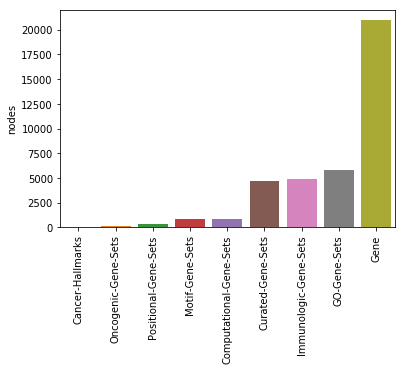

In [34]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

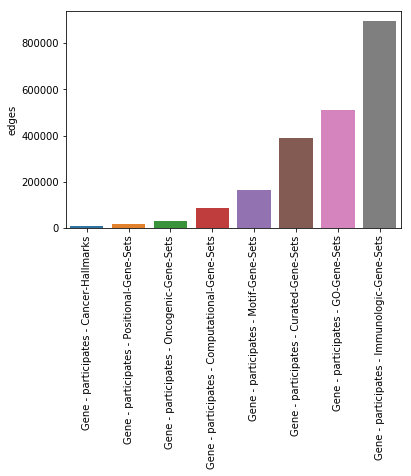

In [35]:
ax = sns.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');